### Import Packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
from collections import Counter
from IPython.display import clear_output

### Create Necessary Functions

In [7]:
def softmax(z, extra_param = None):
    sums = np.sum(np.exp(z))
    return np.exp(z) / sums

def one_hot(y, total_cats = None):
    if total_cats == None:
        y_onehot = np.zeros([len(y), len(np.unique(y))])
    else:
        y_onehot = np.zeros([len(y), total_cats])

    for i in range(len(y)):
        y_onehot[i, y[i]] = 1
        
    return y_onehot

### Create DRNN Class

In [45]:
class DRNN():
    
    def __init__(self, input_dim, hidden_one_dim, hidden_two_dim, bptt_truncate = 4):
        
        self.input_dim = input_dim
        self.hidden_one_dim = hidden_one_dim
        self.hidden_two_dim = hidden_two_dim
        self.bptt_truncate = bptt_truncate
        
        self.U = np.random.uniform(-1 / np.sqrt(self.input_dim), 1 / np.sqrt(self.input_dim),
                                   [self.hidden_one_dim, self.input_dim])
        self.V = np.random.uniform(-1 / np.sqrt(self.hidden_two_dim), 1 / np.sqrt(self.hidden_two_dim),
                                   [self.input_dim, self.hidden_two_dim])
        self.W1 = np.random.uniform(-1 / np.sqrt(self.hidden_one_dim), 1 / np.sqrt(self.hidden_one_dim),
                                   [self.hidden_one_dim, self.hidden_one_dim])
        self.W2 = np.random.uniform(-1 / np.sqrt(self.hidden_two_dim), 1 / np.sqrt(self.hidden_two_dim),
                                   [self.hidden_two_dim, self.hidden_two_dim])
        self.X = np.random.uniform(-1 / np.sqrt(self.hidden_two_dim), 1 / np.sqrt(self.hidden_two_dim),
                                   [self.hidden_two_dim, self.hidden_one_dim])
    
    def forward_propagation(self, X):
        # Total number of time steps
        T = X.shape[0]

        # Matrix to hold the hidden state at each step from 0 to T
        S1 = np.zeros([T + 1, self.hidden_one_dim])
        S2 = np.zeros([T + 1, self.hidden_two_dim])
        # Initialize to zero
        S1[-1, :] = np.zeros([self.hidden_one_dim])
        S2[-1, :] = np.zeros([self.hidden_two_dim])
        
        # Matrix to hold output at each time step
        O = np.zeros([T, self.input_dim])
        
        for t in range(T):
            S1[t, :] = np.tanh(np.dot(self.U, X[t, :]) + np.dot(self.W1, S1[t - 1, :]))
            S2[t, :] = np.tanh(np.dot(self.X, S1[t, :]) + np.dot(self.W2, S2[t - 1, :]))
            O[t, :] = softmax(np.dot(self.V, S2[t, :]))
        return (O, S1, S2)
    
    def predict(self, X):
        O, S1, S2 = self.forward_propagation(X)
        return np.argmax(O, axis = 1)
    
    def calc_total_loss(self, X, y):
        O, S1, S2 = self.forward_propagation(X)
        return -1 * np.sum(np.log(np.sum(y * O, axis = 1))) / X.shape[0]
    
    def random_loss(self):
        return np.log(self.input_dim)
    
    def bptt(self, X, y):
        T = X.shape[0]
        
        O, S1, S2 = self.forward_propagation(X)
        
        dL_dU = np.zeros(self.U.shape)
        dL_dV = np.zeros(self.V.shape)
        dL_dW1 = np.zeros(self.W1.shape)
        dL_dW2 = np.zeros(self.W2.shape)
        dL_dX = np.zeros(self.X.shape)
        
        for t in range(T):
            
            a2_t = np.dot((O - y)[t, :], self.V) * (1 - S2[t, :] ** 2)
            a1_t = np.dot(a2_t, self.X) * (1 - S1[t, :] ** 2)

            for step in range(t, max(t - self.bptt_truncate, -1), -1):
                
                dL_dU += np.outer(a1_t, X[step, :])
                dL_dW1 += np.outer(a1_t, S1[step, :])
                dL_dX += np.outer(a2_t, S1[step, :])
                dL_dW2 += np.outer(a2_t, S2[step, :])
                
                a2_t = np.dot((O - y)[t, :], self.V) * (1 - S2[step - 1, :] ** 2)
                a1_t = np.dot(a2_t, self.X) * (1 - S1[step - 1, :] ** 2)
            
            dL_dV += np.outer((O - y)[t, :], S2[t, :])
        
        return (dL_dU, dL_dV, dL_dW1, dL_dW2, dL_dX)
    
    def sgd_step(self, X, y, lr, eta):
        (dL_dU, dL_dV, dL_dW1, dL_dW2, dL_dX) = self.bptt(X, y)
        
        # Gradient Clipping
        if np.linalg.norm(dL_dU) > eta:
            dL_dU = dL_dU * eta / np.linalg.norm(dL_dU)
        if np.linalg.norm(dL_dV) > eta:
            dL_dV = dL_dV * eta / np.linalg.norm(dL_dV)
        if np.linalg.norm(dL_dW1) > eta:
            dL_dW1 = dL_dW1 * eta / np.linalg.norm(dL_dW1)
        if np.linalg.norm(dL_dW2) > eta:
            dL_dW2 = dL_dW2 * eta / np.linalg.norm(dL_dW2)
        if np.linalg.norm(dL_dX) > eta:
            dL_dX = dL_dX * eta / np.linalg.norm(dL_dX)
        
        self.U = self.U - lr * dL_dU
        self.V = self.V - lr * dL_dV
        self.W1 = self.W1 - lr * dL_dW1
        self.W2 = self.W2 - lr * dL_dW2
        self.X = self.X - lr * dL_dX

### Create Dataset

In [55]:
alice = list(gutenberg.raw('carroll-alice.txt').replace('\n', '').lower())[0:1000]
alice_counter = Counter(alice)

num_letters = len(alice_counter.most_common())
letter_idxs = {alice_counter.most_common()[i][0]: i for i in range(len(alice_counter.most_common()))}

# print(letter_idxs)
    
vocabulary = [word for word in letter_idxs.keys()]
X = [letter_idxs[letter] for letter in alice]
X = one_hot(X)

### Train Model

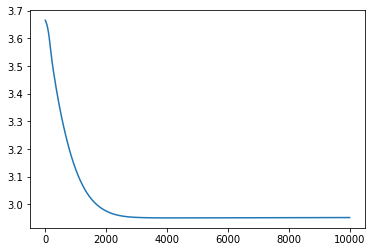

Iteration: 9999 - Current Loss: 2.952680655921208
['a', 'n', 'd', ' ', 'b']
['l', 'i', 'e', 'e', ' ']


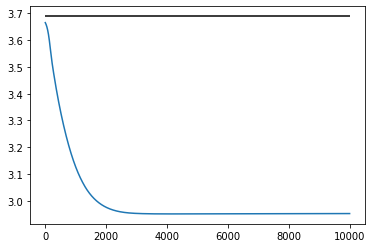

In [68]:
drnn = DRNN(X.shape[1], 16, 4, 4)
losses = []

for i in range(10000):
    if i % 10 == 9:
        clear_output()
        plt.plot(losses)
        plt.show()
        print('Iteration: ' + str(i) + ' - Current Loss: ' + str(losses[-1]))
    drnn.sgd_step(X[0:X.shape[0] - 1], X[1:X.shape[0]], .001, 2)
#     drnn.sgd_step(X, X, .001, 2)
    losses.append(drnn.calc_total_loss(X, X))
    

print([val for val in alice[30:35]])
output = drnn.predict(X[30:35, :])
print([vocabulary[val] for val in output])

plt.plot(losses)
plt.hlines(y = drnn.random_loss(), xmin = 0, xmax = len(losses))

### Generate Text From Trained Model

In [74]:
seed = ['a', 'l']

for i in range(20):
    seed_idx = [letter_idxs[letter] for letter in seed]
    seed_X = one_hot(seed_idx, len(vocabulary))

    output = [vocabulary[val] for val in drnn.predict(seed_X)]
    seed.append(output[-1])
seed

['a',
 'l',
 "'",
 'c',
 'e',
 'e',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ']